# Multilayer Perceptron (MLP)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/01_mlp/mlp.ipynb)

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as Transforms
from torchsummary import summary

from matplotlib import pyplot as plt

## 0. Train parameters

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 5e-4

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
if DEVICE == 'cuda':
    torch.set_float32_matmul_precision('high')

## 1. Prepare datset

In [4]:
def get_dataloaders(batch_size):

    # Dataset classes
    classes = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ])

    # first define a transform funcion, to make images tensors and normalize them
    transform = Transforms.Compose(
        [Transforms.ToTensor(),
         Transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # download Cifar-10 datset
    train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=4)

    return classes, train_loader, test_loader

checking datasets and labels.

Files already downloaded and verified
Files already downloaded and verified


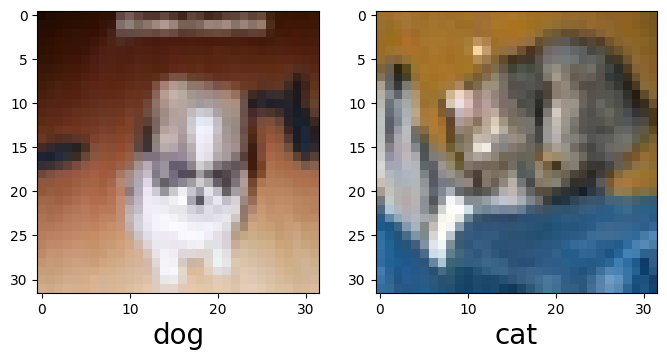

In [5]:
classes, train_loader, test_loader = get_dataloaders(batch_size=8)

check_train_img, check_train_label = next(iter(train_loader))
check_test_img, check_test_label = next(iter(test_loader))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# display the images and corresponded labels

# To plot pytorch normalized image:
# 1. Change the shape: (channel, h, w) -> (h, w, channel)
# 2. Unnormalize image: img / 2 + 0.5
train_img = check_train_img[0].permute(1, 2, 0) / 2 + 0.5
test_img = check_test_img[0].permute(1, 2, 0) / 2 + 0.5

axes[0].imshow(train_img)
axes[0].set_xlabel(classes[check_train_label[0].item()], fontsize=20)
axes[1].imshow(test_img)
axes[1].set_xlabel(classes[check_test_label[0].item()], fontsize=20)

plt.show()

In [6]:
print(check_train_img.shape)

torch.Size([8, 3, 32, 32])


## 2. Define the MLP network

In [7]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(3*32*32), out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=150),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=num_classes)
        )

    def forward(self, x):
        return self.model(x)

Model summary in PyTorch

In [8]:
mlp = MLP(NUM_CLASSES).to(DEVICE)
summary(mlp, (1, 3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 200]         614,600
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 150]          30,150
              ReLU-5                  [-1, 150]               0
            Linear-6                   [-1, 10]           1,510
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 2.47
Estimated Total Size (MB): 2.51
----------------------------------------------------------------


## 3. Define the model, objective, and optimizer

In [9]:
mlp = MLP(num_classes=NUM_CLASSES).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    mlp = torch.compile(mlp) # PyTorch 2.0 feature
    print('model compiled')

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mlp.parameters(), lr=LR)

model compiled


## 4. Get dataloaders

In [10]:
classes, train_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


## 5. Define train and validation functions

In [11]:
def train(model, dataloader, optimizer, loss_fn):
    
    model.train()
    correct_preds = 0
    total_preds = 0
    train_loss = 0.0
    
    for i, (train_x, train_y) in enumerate(dataloader):
        # clear gradients
        optimizer.zero_grad()
        
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        pred_y = model(train_x)
        loss = loss_fn(pred_y, train_y)
        
        loss.backward()
        optimizer.step()

        correct_preds += sum(pred_y.argmax(dim=-1) == train_y).item()
        total_preds += len(pred_y)
        train_loss += loss.item()

    return train_loss / len(dataloader), correct_preds / total_preds


def validate(model, dataloader, loss_fn):
    
    model.eval()    
    correct_preds = 0
    total_preds = 0
    val_loss = 0.0

    for i, (val_x, val_y) in enumerate(dataloader):
        # We need to first send data to the training device
        val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
        # no grad needed in evaluation
        with torch.no_grad():
            pred_y = model(val_x)
            loss = loss_fn(pred_y, val_y)

        val_loss += loss.item()
        correct_preds += sum(pred_y.argmax(dim=-1) == val_y).item()
        total_preds += len(pred_y)

    return val_loss / len(dataloader), correct_preds / total_preds

## 6. Train and evaluate

In [12]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [13]:
for i in range(NUM_EPOCHS):
    train_loss, train_acc = train(mlp, train_loader, optim, loss_fn)
    val_loss, val_acc = validate(mlp, test_loader, loss_fn)

    metrics_history['train_loss'].append(train_loss)
    metrics_history['train_accuracy'].append(train_acc)
    metrics_history['test_loss'].append(val_loss)
    metrics_history['test_accuracy'].append(val_acc)

    print('Epoch {}:'.format(i + 1))
    print(f'\tTrain - loss: {metrics_history["train_loss"][-1]:.4f}, accuracy: {metrics_history["train_accuracy"][-1] * 100:.4f}')
    print(f'\tTest - loss: {metrics_history["test_loss"][-1]:.4f}, accuracy: {metrics_history["test_accuracy"][-1] * 100:.4f}')

Epoch 1:
	Train - loss: 1.6348, accuracy: 42.1440
	Test - loss: 1.5021, accuracy: 47.1300
Epoch 2:
	Train - loss: 1.4235, accuracy: 50.0520
	Test - loss: 1.4106, accuracy: 49.9600
Epoch 3:
	Train - loss: 1.3167, accuracy: 53.6300
	Test - loss: 1.3761, accuracy: 51.6300
Epoch 4:
	Train - loss: 1.2315, accuracy: 56.8300
	Test - loss: 1.3427, accuracy: 53.1500
Epoch 5:
	Train - loss: 1.1641, accuracy: 59.2920
	Test - loss: 1.3324, accuracy: 53.8000
Epoch 6:
	Train - loss: 1.0986, accuracy: 61.2800
	Test - loss: 1.3628, accuracy: 52.8100
Epoch 7:
	Train - loss: 1.0386, accuracy: 63.3900
	Test - loss: 1.3473, accuracy: 54.0600
Epoch 8:
	Train - loss: 0.9823, accuracy: 65.2800
	Test - loss: 1.3690, accuracy: 53.5800
Epoch 9:
	Train - loss: 0.9345, accuracy: 67.2800
	Test - loss: 1.3561, accuracy: 54.1700
Epoch 10:
	Train - loss: 0.8795, accuracy: 68.9640
	Test - loss: 1.4000, accuracy: 54.7400


## 8. Visualize metrics

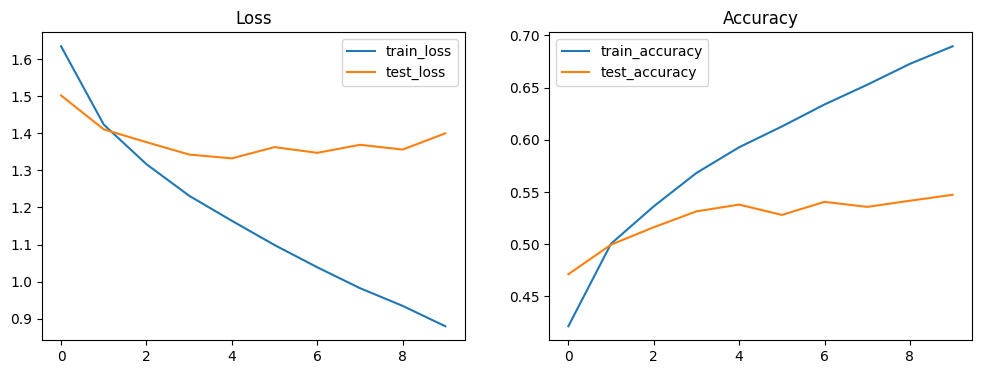

<Figure size 640x480 with 0 Axes>

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 9. Check predictions

In [15]:
imgs, true_labels = next(iter(test_loader))

with torch.no_grad():
    logits = mlp(imgs.to(DEVICE))
    
preds = logits.argmax(-1).detach().cpu()

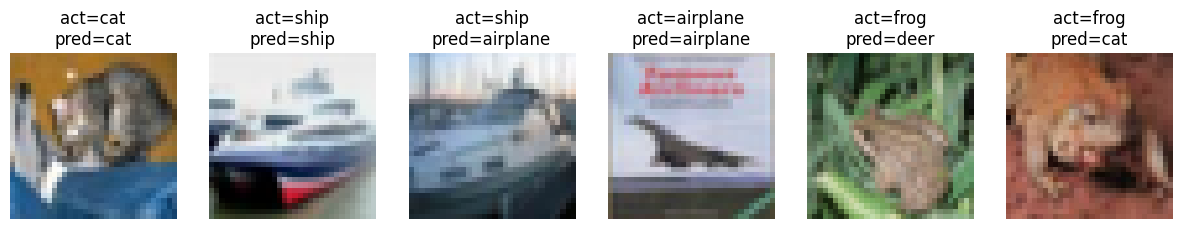

In [16]:
num_to_show = 6
indices = np.random.choice(np.arange(len(imgs)), num_to_show, replace=True)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, idx in enumerate(indices):
    img = imgs[i].permute(1, 2, 0) / 2 + 0.5
    ax = fig.add_subplot(1, num_to_show, i+1, label='test')
    ax.axis('off')
    
    pred_class = classes[preds[i]]
    true_class = classes[true_labels[i]]
    
    ax.imshow(img)
    ax.set_title(f'act={true_class}\npred={pred_class}')

plt.show()